In [47]:
# Import necessary libraries
import librosa
import numpy as np
import os
import pandas as pd
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import IsolationForest
import csv
import whisper
import torch
import warnings

In [ ]:
# Convert MP3 files from data to WAV format
# Define paths
mp3_dir = r'C:/Users/yingx/data/MEMD_audio'
wav_dir = r'C:/Users/yingx/data/WaveFiles'

# Create output directory if it doesn't exist
os.makedirs(wav_dir, exist_ok=True)

# Process files from 2.mp3 to 2058.mp3
for i in range(2, 2059):
    mp3_path = os.path.join(mp3_dir, f'{i}.mp3')
    wav_path = os.path.join(wav_dir, f'{i}.wav')
    
    # Only process if the MP3 file exists
    if os.path.exists(mp3_path):
        try:
            # Load MP3 file with librosa (automatically converts to 22050 Hz mono)
            y, sr = librosa.load(mp3_path, sr=None)  # sr=None keeps original sample rate
            
            # Save as WAV file using soundfile
            sf.write(wav_path, y, sr)
            
            print(f'Successfully converted {i}.mp3 to {i}.wav')
        except Exception as e:
            print(f'Error processing {i}.mp3: {str(e)}')
    else:
        print(f'{i}.mp3 not found, skipping')

print('Conversion complete!')

In [ ]:
# Create features.csv from audio files in a specified directory    
def extract_features(wav_file):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=None)

    # Calculate features
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    chroma_feature = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y))
    harmonicity = np.mean(librosa.effects.harmonic(y))

    # Extract id from filename (e.g., 1 from 1.wav)
    base = os.path.basename(wav_file)
    id_str = os.path.splitext(base)[0]
    id_val = int(id_str)

    return {
        'id': id_val,
        'duration': duration,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate,
        'chroma_feature': chroma_feature.tolist(),
        'mfccs': mfccs.tolist(),
        'rms': rms,
        'harmonicity': harmonicity
    }

def save_features_to_csv(features, csv_file):
    # Create a DataFrame from the features
    df = pd.DataFrame(features)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    # Save to CSV
    columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
    df = df[columns]
    df.to_csv(csv_file, index=False)

def process_file(wav_file):
    if os.path.exists(wav_file):
        features = extract_features(wav_file)
        print(f"Processed: {wav_file}")
        return features
    else:
        print(f"File not found: {wav_file}")
        return None

def safe_extract(wav_file):
    try:
        if os.path.exists(wav_file):
            return extract_features(wav_file)
        else:
            print(f"File not found: {wav_file}")
            return None
    except Exception as e:
        print(f"Error processing {wav_file}: {e}")
        return None

if __name__ == "__main__":
    wav_dir = r'C:\Users\yingx\data\WaveFiles'
    output_csv = r'C:\Users\yingx\data\features.csv'
    # Start from 703.wav since previous files are already processed
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(0, 2059)]
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    batch_size = 100
    header_written = os.path.exists(output_csv)

    for batch_start in range(0, len(wav_files), batch_size):
        batch_files = wav_files[batch_start:batch_start + batch_size]
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(safe_extract, batch_files))
        features_batch = [res for res in results if res is not None]
        if features_batch:
            df = pd.DataFrame(features_batch)
            columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
            df = df[columns]
            df.to_csv(output_csv, mode='a', header=not header_written, index=False)
            header_written = True
        print(f"Processed batch {batch_start} to {batch_start + len(batch_files) - 1}")

    print(f"Feature extraction complete. Features saved to: {output_csv}")

In [ ]:
# Determine if the wav file is vocal or instrumental

def has_vocals(filepath, sr=22050, n_fft=2048, hop_length=512):
    """
    Detect if a WAV file contains vocals using spectral features and anomaly detection.
    Returns True if vocals are detected, False otherwise.
    """
    try:
        # Load audio with librosa (automatically resamples to sr)
        y, sr = librosa.load(filepath, sr=sr)
        
        # Extract features that help distinguish vocals
        S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        spectral_centroid = librosa.feature.spectral_centroid(S=np.abs(S), sr=sr)
        spectral_flatness = librosa.feature.spectral_flatness(S=np.abs(S))
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        
        # Combine features and look for vocal-like anomalies
        features = np.vstack([
            spectral_centroid,
            spectral_flatness,
            mfccs
        ]).T
        
        # Use Isolation Forest to detect vocal segments (anomalies)
        clf = IsolationForest(contamination=0.1, random_state=42)
        preds = clf.fit_predict(features)
        
        # If we find significant anomalies, assume they're vocals
        vocal_segments = np.sum(preds == -1)
        total_segments = len(preds)
        vocal_ratio = vocal_segments / total_segments
        
        return vocal_ratio > 0.15  # Threshold may need adjustment
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return False

def create_vocal_report(input_dir, output_csv='vocal_data.csv', max_files=None):
    """
    Scan WAV files in directory and create CSV report of vocal presence.
    """
    results = []
    processed = 0
    
    # Get sorted list of WAV files (handling missing numbers)
    files = sorted(
        [f for f in os.listdir(input_dir) if f.endswith('.wav')],
        key=lambda x: int(x.split('.')[0])
    )
    
    if max_files:
        files = files[:max_files]
    
    for filename in files:
        filepath = os.path.join(input_dir, filename)
        has_vocal = has_vocals(filepath)
        # Extract id from filename (e.g., 2 from 2.wav)
        id_val = int(os.path.splitext(filename)[0])
        results.append({
            'id': id_val,
            'filename': filename,
            'has_vocal': has_vocal
        })
        processed += 1
        print(f"Processed {processed}/{len(files)}: {filename} - {'VOCALS' if has_vocal else 'no vocals'}")

    # Save to CSV with 'id' as the first column
    df = pd.DataFrame(results)
    df = df[['id', 'filename', 'has_vocal']]
    df.to_csv(output_csv, index=False)
    print(f"Report saved to {output_csv}")
    return df

# Test with first 5 WAV files
input_directory = r'C:\Users\yingx\data\WaveFiles'
create_vocal_report(input_directory, max_files=10)

In [ ]:
# Separate vocals from audio files using spectral masking and NN filter refinement
from vocal import spectral_masking_vocals

def separatevocals(audiofilepath, outputpath):
    """Robust vocal separation with proper non-negative constraint handling"""
    # Load audio with error handling
    try:
        y, sr = librosa.load(audiofilepath, sr=None)
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None

    # First pass: spectral masking
    try:
        vocals, background = spectral_masking_vocals(y, sr)
    except Exception as e:
        print(f"Spectral masking failed: {e}")
        return None

    # Second pass: NN filter refinement with proper non-negative handling
    try:
        # Compute STFT with safe settings
        S = librosa.stft(vocals, n_fft=2048, hop_length=512)
        S_full, phase = librosa.magphase(S)
        
        # NN filter with absolute values to ensure non-negative
        S_filter = librosa.decompose.nn_filter(np.abs(S_full),
                                              aggregate=np.median,
                                              metric='cosine',
                                              width=int(librosa.time_to_frames(2, sr=sr)))
        S_filter = np.minimum(np.abs(S_full), np.abs(S_filter))

        # Ensure non-negative inputs for softmask
        X = np.abs(S_full) - np.abs(S_filter)
        X_ref = np.abs(S_filter)
        
        # Clip to ensure non-negative (add small epsilon to avoid zeros)
        X = np.clip(X, 1e-10, None)
        X_ref = np.clip(X_ref, 1e-10, None)
        
        # Apply softmask with safe parameters
        mask_v = librosa.util.softmask(X, X_ref * 10, power=1.5)
        
        # Reconstruct audio
        vocals_clean = librosa.istft(mask_v * S_full * phase)
        
        # Post-processing
        vocals_clean = librosa.util.normalize(vocals_clean)
        if len(vocals_clean) > 0:
            vocals_clean = librosa.effects.trim(vocals_clean, top_db=25)[0]
            
    except Exception as e:
        print(f"NN filter processing failed: {e}")
        return None

    # Save output
    try:
        os.makedirs(os.path.dirname(outputpath), exist_ok=True)
        sf.write(outputpath, vocals_clean, sr)
        return True
    except Exception as e:
        print(f"Error saving output: {e}")
        return False

def process_all_files(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process files with progress bar
    successful = 0
    failed = 0
    
    for i in tqdm(range(1786, 2059)):  # from 1.wav to 2058.wav
        input_path = os.path.join(input_dir, f"{i}.wav")
        output_path = os.path.join(output_dir, f"{i}.wav")
        
        # Skip if input file doesn't exist
        if not os.path.exists(input_path):
            failed += 1
            continue
            
        # Process the file
        result = separatevocals(input_path, output_path)
        
        if result:
            successful += 1
            # Append id and filename for possible CSV output
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'success'})
        else:
            failed += 1
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'failed'})
            
    print(f"\nProcessing complete! Successful: {successful}, Failed: {failed}")

# Set your directories
input_directory = r'C:\Users\yingx\data\WaveFiles'
output_directory = r'C:\Users\yingx\data\VocalFiles'

# Run the processing
process_all_files(input_directory, output_directory)

In [ ]:
# Determine if the wav file is vocal or instrumental using energy and zero-crossing rate

# Configuration
input_folder = r'C:\Users\yingx\data\Output'
output_csv = r'C:\Users\yingx\data\Instrumental.csv'
file_pattern = '{}_vocals.wav'  # Pattern for filenames
total_files = 2058  # Total number of files to process

# Adjusted thresholds
RMS_ENERGY_THRESHOLD = -28  # dB - for overall energy
ZCR_THRESHOLD = 1000       # Zero-crossing rate threshold (vocal sounds typically have higher ZCR)

def is_vocal(file_path, energy_threshold=RMS_ENERGY_THRESHOLD, zcr_threshold=ZCR_THRESHOLD):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None, mono=True)
        
        # Calculate features
        rms = librosa.feature.rms(y=y)
        db = librosa.amplitude_to_db(rms, ref=np.max)
        avg_db = np.mean(db)
        
        # Calculate zero-crossing rate (vocal sounds typically have higher ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)
        avg_zcr = np.mean(zcr) * sr  # Scale by sample rate
        
        # Vocal detection logic
        # Needs both sufficient energy and characteristic vocal ZCR
        return avg_db > energy_threshold and avg_zcr > zcr_threshold
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return False

# Process all files
results = []
for i in range(1, total_files + 1):
    filename = file_pattern.format(i)
    file_path = os.path.join(input_folder, filename)
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    has_vocals = is_vocal(file_path)
    # Extract id from filename (e.g., 2 from 2_vocals.wav)
    id_val = int(filename.split('_')[0])
    results.append({'id': id_val, 'filename': filename, 'has_vocals': has_vocals})
    
    # Print progress every 100 files
    if i % 100 == 0:
        print(f"Processed {i}/{total_files} files")

# Create DataFrame and save to CSV with 'id' as the first column
df = pd.DataFrame(results)
df = df[['id', 'filename', 'has_vocals']]
df.to_csv(output_csv, index=False)

print(f"Processing complete. Results saved to {output_csv}")

In [ ]:
# Transcribes all detected vocal audio files (as marked in a CSV) in a directory using the Whisper large model and saves the transcriptions to a CSV file.

warnings.filterwarnings("ignore")  # Suppress warnings

# Set device for Whisper (use GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Directory paths
input_dir = r"C:\Users\yingx\data\Output"
instrumental_csv = r"C:\Users\yingx\data\Instrumental.csv"
output_file = r"C:\Users\yingx\data\transcriptions.csv"

# Load Whisper large model
print("Loading Whisper large model...")
model = whisper.load_model("large", device=device)
print("Model loaded successfully!")

def get_vocal_files(directory, csv_path, limit=None):
    """Get vocal files marked in the CSV, but convert to _vocals.wav format"""
    # Read the CSV file
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        # Get base filenames without extension from CSV
        base_files = [row['filename'].replace('.wav', '') for row in reader if row.get('has_vocals') == 'True']
    
    # Convert to the actual vocal filenames (add _vocals.wav)
    vocal_files = []
    for base_file in base_files:
        vocal_filename = f"{base_file}.wav"
        filepath = os.path.join(directory, vocal_filename)
        if os.path.exists(filepath):
            vocal_files.append(filepath)
        else:
            print(f"Warning: File not found - {vocal_filename}")
    
    # Sort by numerical order (extract number from filename)
    vocal_files.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))
    
    # Apply limit if specified
    return vocal_files[:limit] if limit is not None else vocal_files

def transcribe_file(filepath):
    """Transcribe a single file using Whisper"""
    # Transcribe the audio file
    result = model.transcribe(filepath)
    return result["text"]

def main():
    # Get all vocal files from the CSV that exist in the input directory
    vocal_files = get_vocal_files(input_dir, instrumental_csv)
    
    if not vocal_files:
        print("No vocal files found in the input directory.")
        return
    
    print(f"Found {len(vocal_files)} vocal files to process")
    
    # Prepare the output data
    results = []
    total_files = len(vocal_files)
    
    for i, filepath in enumerate(vocal_files, 1):
        filename = os.path.basename(filepath)
        # Extract id from filename (e.g., 2 from 2_vocals.wav)
        id_val = int(filename.split('_')[0])
        print(f"Processing {filename} ({i}/{total_files})...")
        
        try:
            text = transcribe_file(filepath)
            results.append([id_val, filename, text])
            print(f"Completed: {filename}")
            print(f"Transcription preview: {text[:100]}..." if text else "No transcription generated")
            
            # Save progress after each file to avoid losing data
            if i % 5 == 0 or i == total_files:  # Save more frequently
                with open(output_file, 'w', newline='', encoding='utf-8') as f:
                    writer = csv.writer(f)
                    writer.writerow(["filename", "transcription"])
                    writer.writerows(results)
                print(f"Progress saved after {i} files")
                
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            results.append([id_val, filename, f"ERROR: {str(e)}"])
    
    # Final save
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "transcription"])
        writer.writerows(results)
    
    print(f"Transcriptions saved to {output_file}")

if __name__ == "__main__":
    main()

In [44]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Prepare the emotion.csv, features.csv, instrumental.csv, static_annotations_averaged_songs.csv, and transcriptions.csv files for CNN training
# Load CSV files
df_features = pd.read_csv(r'C:\Users\yingx\data\features.csv') #id,duration,tempo,spectral_centroid,zero_crossing_rate,chroma_feature,mfccs,rms,harmonicity
df_instrumental = pd.read_csv(r'C:\Users\yingx\data\Instrumental.csv') #id,has_vocals
df_transcriptions = pd.read_csv(r'C:\Users\yingx\data\transcriptions.csv') #id,transcription
df_emotion = pd.read_csv(r'C:\Users\yingx\data\emotion.csv') #id, emotion
df_static_averaged = pd.read_csv(r'C:\Users\yingx\data\annotations\annotations averaged per song\song_level\static_annotations_averaged_songs_1_2000.csv') # song_id,valence_mean,valence_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_mean,arousal_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std

def get_train():
    # Merge dataframes on 'id'
    df = df_features.merge(df_instrumental, on='id')
    df = df.merge(df_transcriptions, on='id')
    df = df.merge(df_static_averaged, on='id')
    df = df.merge(df_emotion, on='id')
    #df.size = 199,16

    # Convert string representations of lists back to actual lists
    def parse_list_string(list_str):
        if isinstance(list_str, str):
            return [float(x.strip()) for x in list_str.strip('[]').split(',') if x.strip()]
        return list_str

    list_columns = ['chroma_feature', 'mfccs']
    for col in list_columns:
        df[col] = df[col].apply(parse_list_string)

    # Feature engineering: combine scalar, chroma, mfccs, and static annotation features
    features = []
    for _, row in df.iterrows():
        feature_vector = []

        # Scalar features
        scalar_features = [
            row['duration'],
            row['tempo'],
            row['spectral_centroid'],
            row['zero_crossing_rate'],
            row['rms'],
            row['harmonicity'],
            float(row['has_vocals'])
        ]
        feature_vector.extend(scalar_features)

        # Chroma features
        feature_vector.extend(row['chroma_feature'])

        # MFCC features (first 13 coefficients)
        feature_vector.extend(row['mfccs'][:13])

        # Static annotation features (example: use all columns except song_id)
        static_cols = [col for col in df_static_averaged.columns if col != 'song_id']
        feature_vector.extend([row[c] for c in static_cols])

        features.append(feature_vector)

    # Prepare labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['emotion'])
    y_categorical = to_categorical(y)

    X = np.array(features)
    # X = (199, 37) y_categorical = (199, 4) df = (199, 16)
    return X, y_categorical, label_encoder, df

print("-----Train Data-----")
X_train, y_categorical, label_encoder, df_train = get_train()
print(df_train.columns) 
#print(df.head())

def get_test():
    #Merge features.csv, instrumental.csv, static_annotations_averaged_songs.csv, and transcriptions.csv files for CNN training but minus id on emotion
    # Merge all dataframes on 'id'
    df = df_features.merge(df_instrumental, on='id')
    df = df.merge(df_transcriptions, on='id')
    df = df.merge(df_static_averaged, on='id')

    # Convert string representations of lists back to actual lists
    def parse_list_string(list_str):
        if isinstance(list_str, str):
            return [float(x.strip()) for x in list_str.strip('[]').split(',') if x.strip()]
        return list_str

    list_columns = ['chroma_feature', 'mfccs']
    for col in list_columns:
        df[col] = df[col].apply(parse_list_string)

    # Feature engineering: combine scalar, chroma, mfccs, and static annotation features
    features = []
    for _, row in df.iterrows():
        feature_vector = []

        # Scalar features
        scalar_features = [
            row['duration'],
            row['tempo'],
            row['spectral_centroid'],
            row['zero_crossing_rate'],
            row['rms'],
            row['harmonicity'],
            float(row['has_vocals'])
        ]
        feature_vector.extend(scalar_features)

        # Chroma features
        feature_vector.extend(row['chroma_feature'])

        # MFCC features (first 13 coefficients)
        feature_vector.extend(row['mfccs'][:13])

        # Static annotation features (example: use all columns except song_id)
        static_cols = [col for col in df_static_averaged.columns if col != 'song_id']
        feature_vector.extend([row[c] for c in static_cols])

        features.append(feature_vector)

    X_test = np.array(features)
    # X_test = (522, 15) df_test = (522, 15)
    return X_test, df

print("------Test Data-----")
X_test, df_test = get_test()
print(df_test.columns)
#print(df_test.head())

-----Train Data-----
Index(['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
       'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'has_vocals',
       'transcription', 'valence_mean', 'valence_std', 'arousal_mean',
       'arousal_std', 'emotion'],
      dtype='object')
------Test Data-----
Index(['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
       'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'has_vocals',
       'transcription', 'valence_mean', 'valence_std', 'arousal_mean',
       'arousal_std'],
      dtype='object')


In [48]:
# Define the CNN-Transformer model
def create_cnn_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = inputs

    # 1D Convolutional layers
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)

    # Transformer block
    x = Dense(128)(x)
    x = LayerNormalization()(x)

    # MultiHeadAttention expects query, key, value with same shape
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = Add()([attention_output, x])  # Residual connection

    # Global pooling instead of flatten to handle variable length
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Reshape your data for 1D convolution
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create the model
input_shape = (X_train.shape[1], 1)
num_classes = y_categorical.shape[1]
model = create_cnn_transformer_model(input_shape, num_classes)

# Split your training data for validation
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_reshaped, y_categorical, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(X_train_split, y_train_split, 
                    validation_data=(X_val_split, y_val_split), 
                    epochs=20, batch_size=32)

Epoch 1/20
5/5 [==============================] - 2s 86ms/step - loss: 1.5243 - accuracy: 0.2956 - val_loss: 1.3150 - val_accuracy: 0.3500
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 1.5136 - accuracy: 0.2579 - val_loss: 1.2612 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 0s 19ms/step - loss: 1.3569 - accuracy: 0.4088 - val_loss: 1.2196 - val_accuracy: 0.5750
Epoch 4/20
5/5 [==============================] - 0s 25ms/step - loss: 1.3114 - accuracy: 0.3899 - val_loss: 1.2497 - val_accuracy: 0.3750
Epoch 5/20
5/5 [==============================] - 0s 25ms/step - loss: 1.2867 - accuracy: 0.4214 - val_loss: 1.1851 - val_accuracy: 0.4750
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 1.2865 - accuracy: 0.3836 - val_loss: 1.1575 - val_accuracy: 0.4250
Epoch 7/20
5/5 [==============================] - 0s 21ms/step - loss: 1.2296 - accuracy: 0.4088 - val_loss: 1.1750 - val_accuracy: 0.4750
Epoch 8/20
5/5 [===========

2/2 [==============================] - 0s 2ms/step - loss: 1.2037 - accuracy: 0.5250
Validation Accuracy: 0.52


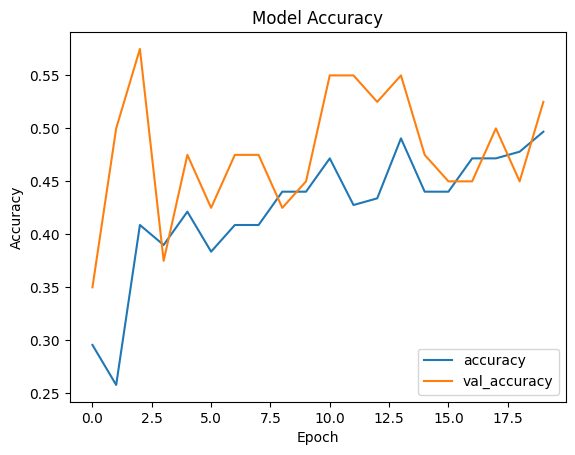

In [50]:
# Evaluate the model on the validation split
loss, accuracy = model.evaluate(X_val_split, y_val_split)
print(f'Validation Accuracy: {accuracy:.2f}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

